<a href="https://colab.research.google.com/github/AndreiTsvirko/DataScience/blob/main/HW3/HW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Создание БД и таблицы

In [1]:
import sqlite3
import os
#Создадим саму БД
def create_database():
    try:
        if os.path.exists('autompg.db'):
            print(" База данных autompg.db существует")
            return

        conn = sqlite3.connect('autompg.db')
        print("База данных autompg.db создана успешно.")
        conn.close()

    except Exception as e:
        print(f"Ошибка при создании базы данных: {e}")
#Cоздадим таблицу
def create_table():
    try:
        conn = sqlite3.connect('autompg.db')
        cursor = conn.cursor()

        cursor.execute("""
        SELECT name FROM sqlite_master
        WHERE type='table' AND name='automobiles'
        """)

        if cursor.fetchone():
            print(" Таблица automobiles уже существует.")
            cursor.close()
            conn.close()
            return

        create_table_query = """
        CREATE TABLE automobiles (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            mpg REAL,
            cylinders INTEGER,
            displacement REAL,
            horsepower REAL,
            weight REAL,
            acceleration REAL,
            model_year INTEGER,
            origin TEXT,
            car_name TEXT,
            manufacture_date TEXT
        )
        """

        cursor.execute(create_table_query)
        conn.commit()
        print("  Таблица automobiles создана успешно!")
        print("  Структура таблицы:")
        print("   - mpg: REAL (расход топлива)")
        print("   - cylinders: INTEGER (количество цилиндров)")
        print("   - displacement: REAL (объем двигателя)")
        print("   - horsepower: REAL (мощность)")
        print("   - weight: REAL (вес)")
        print("   - acceleration: REAL (ускорение)")
        print("   - model_year: INTEGER (год модели)")
        print("   - origin: TEXT (страна происхождения)")
        print("   - car_name: TEXT (название автомобиля)")
        print("   - manufacture_date: TEXT (дата производства)")

        cursor.close()
        conn.close()

    except Exception as e:
        print(f" Ошибка при создании таблицы: {e}")




#Имортируем данные

In [2]:
import pandas as pd
import sqlite3
#Загрузим датасет autoMPG
def download_and_prepare_data():
    try:
        url = "https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data"

        # Названия столбцов
        column_names = ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight',
                        'acceleration', 'model_year', 'origin', 'car_name']
        # Чтение данных из файла
        df = pd.read_csv(url, sep=r'\s+', names=column_names, na_values='?')
        # Добавляем столбец с датой производства
        df['manufacture_date'] = pd.to_datetime(
            df['model_year'].apply(lambda x: f"19{int(x)}-01-01"),
            format='%Y-%m-%d',
            errors='coerce'
        )

        # Присвоим кодам стран текстровые значения
        df['origin'] = df['origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})

        # Удаляем строки с пропущенными значениями
        df = df.dropna()

        # Проверяем данные
        print(f" Данные загружены: {df.shape[0]} строк, {df.shape[1]} столбцов")
        print(f" Диапазон дат: {df['model_year'].min()} - {df['model_year'].max()}")

        return df

    except Exception as e:
        print(f" Ошибка при загрузке данных: {e}")
        return None

#Покажем данные 10 первых строк
def view_first_10_dataset(df):
    if df is None:
        print(" Нет данных для отображения")
        return

    print("\n ПЕРВЫЕ 10 СТРОК ДАТАСЕТА AUTOMPG:")
    print("*" * 108)
    # Выбираем только нужные колонки для отображения
    display_columns = ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight',
                      'acceleration', 'model_year', 'origin', 'car_name']
    print(df[display_columns].head(10).to_string(index=False))
    print("*" * 108)
#Импортируем данне в созданную выше таблицу БД
def import_to_database(df):

    try:
        if df is None:
            print(" Нет данных для импорта")
            return

        conn = sqlite3.connect('autompg.db')
        cursor = conn.cursor()

        # Очищаем таблицу перед импортом
        cursor.execute("delete from automobiles")

        # Вставляем данные
        success_count = 0
        for index, row in df.iterrows():
            try:
                cursor.execute("""
                INSERT INTO automobiles
                (mpg, cylinders, displacement, horsepower, weight, acceleration,
                 model_year, origin, car_name, manufacture_date)
                VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
                """, (
                    float(row['mpg']),
                    int(row['cylinders']),
                    float(row['displacement']),
                    float(row['horsepower']),
                    float(row['weight']),
                    float(row['acceleration']),
                    int(row['model_year']),
                    str(row['origin']),
                    str(row['car_name']),
                    row['manufacture_date'].strftime('%Y-%m-%d') if pd.notna(row['manufacture_date']) else '1900-01-01'
                ))
                success_count += 1
            except Exception as insert_error:
                print(f"!!! Ошибка при вставке строки {index}: {insert_error}")
                continue

        # Фиксируем изменения в базе данных
        conn.commit()
        print(f" Данные успешно импортированы в Таблицу БД ({success_count} из {len(df)} записей)")

        cursor.execute("SELECT COUNT(*) FROM automobiles")
        count = cursor.fetchone()[0]
        print(f" Всего записей в базе: {count}")

        cursor.close()
        conn.close()
    except Exception as e:
        print(f"!!! Ошибка при импорте данных: {e}")

#Запросы

In [3]:
import sqlite3
#Запросы с условиями
def execute_filter_queries():
    try:
        conn = sqlite3.connect('autompg.db')
        cursor = conn.cursor()

        print(" \n")

        print("  Автомобили с расходом более 40 mpg:")
        cursor.execute("""
        SELECT car_name, mpg, cylinders, origin
        FROM automobiles
        WHERE mpg > 40
        ORDER BY mpg DESC
        """)

        results = cursor.fetchall()
        print(f" Найдено {len(results)} автомобилей с расходом > 40 mpg")
        for row in results:
            print(f"   {row[0]} - {row[1]} mpg, {row[2]} цилиндров, {row[3]}")

        print(" \n")
        print("  Американские автомобили с 4 цилиндрами:")
        cursor.execute("""
        SELECT car_name, mpg, horsepower, weight
        FROM automobiles
        WHERE cylinders = 4 AND origin = 'USA'
        LIMIT 10
        """)

        results = cursor.fetchall()
        print(f" Найдено {len(results)} американских автомобилей с 4 цилиндрами")
        for row in results:
            print(f"   {row[0]} - {row[1]} mpg, {row[2]} л.с., {row[3]} кг")

        cursor.close()
        conn.close()

    except Exception as e:
        print(f" Ошибка при выполнении запросов: {e}")
#Агрегатные функции
def execute_aggregate_queries():

    try:
        conn = sqlite3.connect('autompg.db')
        cursor = conn.cursor()

        print("\n  Средний расход топлива по странам:")
        cursor.execute("""
        SELECT origin, AVG(mpg), COUNT(*)
        FROM automobiles
        GROUP BY origin
        ORDER BY AVG(mpg) DESC
        """)

        results = cursor.fetchall()
        for row in results:
            print(f"   {row[0]}: {row[1]:.2f} mpg ({row[2]} автомобилей)")

        print(" \n")
        print(" Статистика по количеству цилиндров:")
        cursor.execute("""
        SELECT cylinders, COUNT(*), AVG(mpg), AVG(horsepower)
        FROM automobiles
        GROUP BY cylinders
        ORDER BY cylinders
        """)

        results = cursor.fetchall()
        for row in results:
            print(f"   {row[0]} цилиндров: {row[1]} авто, {row[2]:.1f} mpg, {row[3]:.1f} л.с.")

        cursor.close()
        conn.close()

    except Exception as e:
        print(f" Ошибка при выполнении агрегатных запросов: {e}")

#Визуализация - графики

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import sqlite3
#Граифик
def visualize_data():
    try:
        conn = sqlite3.connect('autompg.db')

        #  Средний расход по годам
        df_mpg_by_year = pd.read_sql("""
        SELECT model_year, AVG(mpg) as avg_mpg
        FROM automobiles
        GROUP BY model_year
        ORDER BY model_year
        """, conn)

        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(df_mpg_by_year['model_year'], df_mpg_by_year['avg_mpg'],
                marker='o', linewidth=2, markersize=6, color='blue')
        plt.title('Средний расход топлива по году выпуска')
        plt.xlabel('Год выпуска')
        plt.ylabel('MPG (миль на галлон)')
        plt.grid(True, alpha=0.3)

        # Страна производства
        df_origin = pd.read_sql("""
        SELECT origin, COUNT(*) as count
        FROM automobiles
        GROUP BY origin
        """, conn)

        plt.subplot(1, 2, 2)
        plt.pie(df_origin['count'], labels=df_origin['origin'], autopct='%1.1f%%',
                colors=['#ff9999','#66b3ff','#99ff99'])
        plt.title('География производства авто')
        plt.tight_layout()
        plt.show()

        # Зависимость расхода от объема двигателя
        df_displacement = pd.read_sql("""
        SELECT displacement, mpg, origin
        FROM automobiles
        ORDER BY displacement
        """, conn)

        plt.figure(figsize=(10, 6))
        colors = {'USA': 'red', 'Europe': 'blue', 'Japan': 'green'}

        for origin in df_displacement['origin'].unique():
            subset = df_displacement[df_displacement['origin'] == origin]
            plt.scatter(subset['displacement'], subset['mpg'],
                       alpha=0.6, label=origin, c=colors[origin], s=50)

        plt.title('Зависимость расхода топлива от объема двигателя')
        plt.xlabel('Объем двигателя (кубические дюймы - увы)')
        plt.ylabel('MPG (миль на галлон)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

        # Расход топлива в зависимости от массы авто
        df_weight = pd.read_sql("""
        SELECT weight, mpg, origin
        FROM automobiles
        ORDER BY weight
        """, conn)

        plt.figure(figsize=(10, 6))

        for origin in df_weight['origin'].unique():
            subset = df_weight[df_weight['origin'] == origin]
            plt.scatter(subset['weight'], subset['mpg'],
                       alpha=0.6, label=origin, c=colors[origin], s=50)

        plt.title('Расход топлива в зависимости от массы авто')
        plt.xlabel('Вес (фунты)')
        plt.ylabel('MPG (миль на галлон)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

        conn.close()
        print(" Графики построены.")

    except Exception as e:
        print(f" Ошибка при визуализации данных: {e}")


#Исполняемый модуль

 МОДУЛЬ autoMPG ЗАПУЩЕН.

1.  Создание базы данных.
База данных autompg.db создана успешно.

2.  Создание таблицы.
  Таблица automobiles создана успешно!
  Структура таблицы:
   - mpg: REAL (расход топлива)
   - cylinders: INTEGER (количество цилиндров)
   - displacement: REAL (объем двигателя)
   - horsepower: REAL (мощность)
   - weight: REAL (вес)
   - acceleration: REAL (ускорение)
   - model_year: INTEGER (год модели)
   - origin: TEXT (страна происхождения)
   - car_name: TEXT (название автомобиля)
   - manufacture_date: TEXT (дата производства)

3. Загрузка и импорт данных из датасета autoMPG.
 Данные загружены: 392 строк, 10 столбцов
 Диапазон дат: 70 - 82

 ПЕРВЫЕ 10 СТРОК ДАТАСЕТА AUTOMPG:
************************************************************************************************************
 mpg  cylinders  displacement  horsepower  weight  acceleration  model_year origin                  car_name
18.0          8         307.0       130.0  3504.0          12.0          

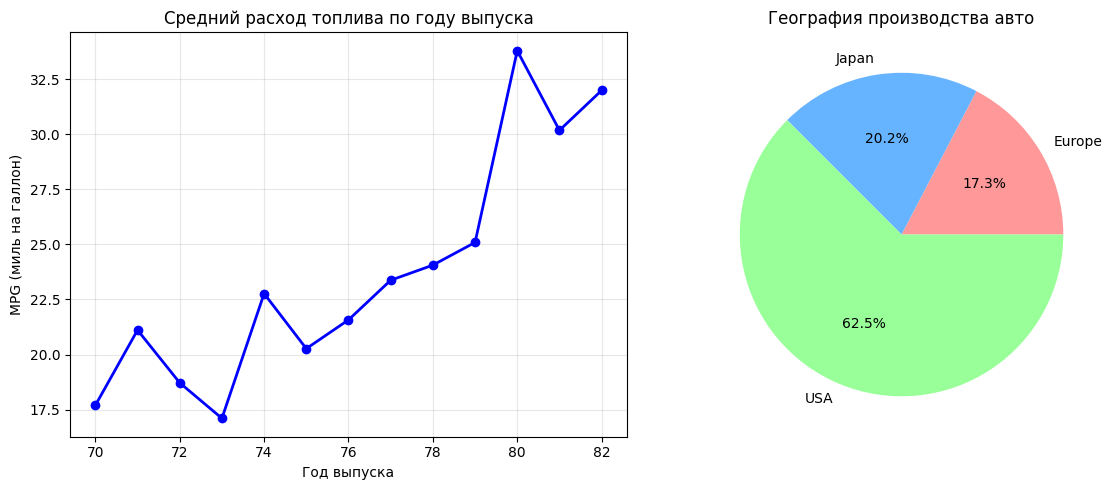

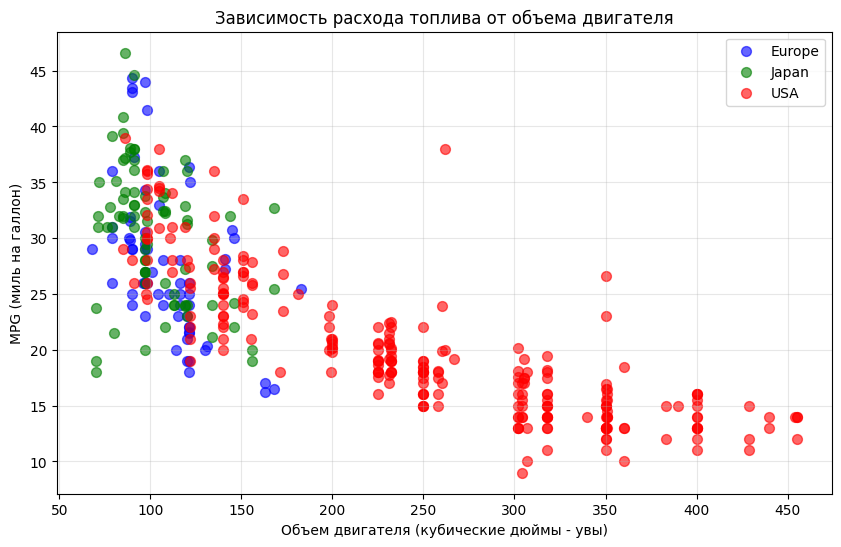

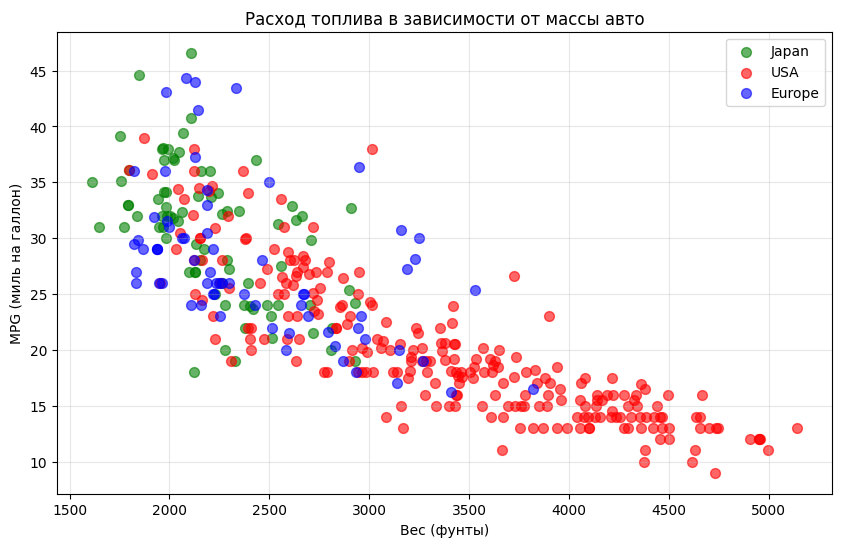

 Графики построены.


 Модуль выполнен успешно!




In [5]:
from database import create_database, create_table
from data_import import download_and_prepare_data, import_to_database, view_first_10_dataset
from queries import execute_filter_queries, execute_aggregate_queries
from visualization import visualize_data
#разбор модулей
def main():

    print(" МОДУЛЬ autoMPG ЗАПУЩЕН.")

    try:
        print("\n1.  Создание базы данных.")
        create_database()

        print("\n2.  Создание таблицы.")
        create_table()

        print("\n3. Загрузка и импорт данных из датасета autoMPG.")
        df = download_and_prepare_data()

        if df is not None:
            view_first_10_dataset(df)
            import_to_database(df)

            print("\n4. Выполнение SQL-запросов")
            execute_filter_queries()

            print("\n5. Выполнение SQL-запросов с агрегатными функциями ")
            execute_aggregate_queries()

            print("\n6. Визуализация данных")
            visualize_data()
        else:
            print(" Не удалось загрузить данные.")

    except Exception as e:
        print(f" Ошибка: {e}")

    print("\n")
    print(" Модуль выполнен успешно!")
    print("\n")

if __name__== "__main__":
    main()